# Chatbot M2DS 2019

In [1]:
from __future__ import unicode_literals, print_function, division
import os
from io import open
import unicodedata
import string
import re
import random
import pickle
# package a installer d'abord avec anaconda
#import spacy

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

# package a installer d'abord avec anaconda
import gensim
from gensim.models import KeyedVectors

#import nltk
#nltk.download()
#from nltk.tokenize import sent_tokenize, word_tokenize

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

import unidecode
from unidecode import unidecode

C:\ProgramData\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
import time
import math
import re
import json

In [3]:
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

USE_CUDA = torch.cuda.is_available()
print(USE_CUDA)
device = torch.device("cuda" if USE_CUDA else "cpu")

True


# 1 Training data preparation

### 1.1 Simple formatting of training dialogues

In [4]:
# -------------------- enlèvement des stopwords ---------------------------------------
def TrimWordsSentence(sentence, stopwords):
    '''Remove stopwords from a sentence'''
    resultwords = [word for word in sentence if word.lower() not in stopwords]
    return resultwords

def TrimWordsDialogue(dialogue, stopwords):
    '''Remove stopwords from user utterances in a dialogue'''
    for pair in dialogue: 
        pair[0] = TrimWordsSentence(pair[0], stopwords)
        #pair[1] = pair[1].strip()
    return dialogue

def TrimWords(dialogues, stopwords):
    '''Remove stopwords from user utterances in a list of dialogues'''
    return [TrimWordsDialogue(dialogue, stopwords) for dialogue in dialogues ]

    


# --------------------------- Normalisation -------------------------------
def normalizeString(s):
    '''Remove rare symbols from a string'''
    def unicodeToAscii(s):
        """Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427"""
        return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"[^a-zA-Z0-9?&\%\-\_]+", r" ", s) 
    return s 



#--------------------- import des dialogues --------------------
def importDialogues(fichier, limite = None):
    '''Import a textfile containing dialogues and returns a list, each element 
       corresponding to a dialogue and also being under the form of a list, with 
       each element being a list of two elements : an element giving a user 
       utterance and another element giving the bot response. Both elements are 
       normalized strings.
       Ex. The dialogue :
       
               hi    hello what can i help you with today
               can you book a table    i m on it
               
       now becomes :
       
              [['hi', 'hello what can i help you with today'], 
               ['can you book a table', 'i m on it']]
               
       Lines corresponding to user utterance with no bot response are discarted.
    '''
    dialogues_import = open(fichier, encoding='utf-8').read().strip().split('\n\n')
    dialogues = []
    for i, d in enumerate(dialogues_import):
        dialogue = []
        lines = d.split('\n')
        for l in lines:
            if len(l.split('\t')) == 2 :
                pair = [normalizeString(s).split(' ') for s in l.split('\t')]
                dialogue.append(pair)
        dialogues.append(dialogue)
        if limite is not None and i == limite -1 :
            break

    return dialogues






#------------------ Dictionnaire des mots variables -----------------------------
def motVar(file):
    '''Applies to the Master's program dataset.
       Import the collection of pairs token-content for a set of variable words.
    '''
    lines = open(file, encoding='utf-8').read().strip().split('\n')
    motsVar = {}
    for l in lines :
        cle, valeur = l.split('\t')
        motsVar[cle.lower()] = valeur
    return motsVar




# ----------------------- Création de la liste des dialogues--------------------
def prepareData(opt):
    '''Import dialogue from text file and apply some formatting operations,
       as described in the functions 
               - importDialogues
               - modify
               - TrimWords
               - filterDialogues
    '''
    dialogues = importDialogues(fichier = opt['fichier'], 
                                limite = opt['limite'])
    dialogues = modify(dialogues) if opt['modify'] else dialogues
    dialogues = TrimWords(dialogues, opt['stopwords']) # on enlève les stopwords de chaque question
    print(" %s dialogues ..." % len(dialogues))
    print(dialogues[0])
    if opt['filtre'] :
        #for pair in [pair for pair in pairs if not filterPair(pair)]:
        #    print('%s (%d) -> %s (%d)' % (pair[0],len(pair[0].split()),pair[1],len(pair[1].split())))  
        dialogues = filterDialogues(dialogues, opt['max_length'])
        print('')
        print("... reduced to %s dialogues" % len(dialogues))

    return dialogues

In [5]:
motsVar = motVar('C:\\Users\Jb\Desktop\Scripts\data\Conversations_M2DS\\chatbot-M2-DS-Variables.txt')

Turn each dialogue of the corpus into torch variables

In [6]:
def variableFromSentence(lang, sentence, rand = 0): # sentence = [str]
    indexes=[]
    unknowns = 0
    for word in sentence:
        p = random.random()
        if word not in lang.word2index.keys() and 'UNK' in lang.word2index.keys() :
            #pass
            indexes.append(lang.word2index['UNK'])
        elif p >= rand :
            indexes.append(lang.word2index[word])
        elif p < rand :
            e = random.choice([1, 2])
            if e == 1 :  # doesn't put any word
                pass
            elif e == 2 and 'UNK' in lang.word2index.keys() :# hide word with UNK_Token
                indexes.append(lang.word2index['UNK'])
    indexes.append(lang.word2index['EOS'])                                
    result = Variable(torch.LongTensor([[i] for i in indexes]))
    return result

def variableFromDialogue(lang, dialogue, rand = 0): # sentence = [str]
    result = []
    for paire in dialogue :
        el1 = variableFromSentence(lang, paire[0], rand = rand)
        el2 = variableFromSentence(lang, paire[1], rand = 0)
        result.append([el1, el2])
    return result

def variableFromAllDialogues(lang, dialogues, rand = 0): # sentence = [str]
    result = []
    for dialogue in dialogues :
        result.append(variableFromDialogue(lang, dialogue, rand = 0))
    return result

### 1.2 Language class

In [7]:
SOS_token = 0
EOS_token = 1
UNK_token = 2

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {"SOS" : 0, "EOS" : 1, "UNK" : 2}
        self.word2count = {"SOS" : 0, "EOS" : 0, "UNK" : 0}
        self.index2word = {0: "SOS", 1: "EOS", 2: "UNK"}
        self.n_words = 3  # Counts SOS and EOS and UNK

        
    def addWord(self, word):
        '''Add a word to the language'''
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1
            
            
    def addSentence(self, sentence):
        '''Add to the language all words of a sentence'''
        for word in sentence:
            self.addWord(word)
            
            
    def addDialogues(self, dialogues, i):
        '''Add to the language all words contained into : either all user utterances 
          (if i = 0) or all bot utterances (if i = 1), of a list of dialogues'''
        for dialogue in dialogues :
            for pair in dialogue:
                try :
                    self.addSentence(pair[i])
                except IndexError:
                    print("Problem with {}".format(pair))

In [8]:
def generateLanguages(dialogues):
    '''Generate three languages classes out of a list of dialogues :
            - input_lang containing the user's vocabulary
            - output lang containing the bot vocabulary
            - output_sentence_lang containing the bot answers as words of a vocabulary
    '''
    lang = Lang('M2DS')
    
    lang.addDialogues(dialogues, 0)
    lang.addDialogues(dialogues, 1)
    print("Mots comptés :")
    print(lang.name, lang.n_words)
    
    return lang


def ajout(dialogues, lang, i= 1):
    '''addDialogues method of the Lang class with prints.'''
    lang.addDialogues(dialogues, i)
    print(lang.name, lang.n_words)
    return lang 


def ajoutSentences(dialogues, sentences_lang, i = 1) :
    '''Add sentences as words to a given language'''
    for dialogue in dialogues :
        for pair in dialogue :
            try :
                sentences_lang.addWord(pair[i])
            except IndexError:
                print("Problem with {}".format(pair))
                
    return sentences_lang

# 3 Chatbot

## 3.1 Word encoder

Le module **RecurrentWordsEncoder** encode une séquence de mots $w_1, ..., w_T$ en une séquence de vecteurs $h_1, ..., h_T$ en appliquant un plongement suivi d'une couche GRU bi-directionnelle. On peut représenter son fonctionnement par la figure suivante :


![WordEncoder](figs/WordEncoder.png)

In [9]:
class RecurrentWordsEncoder(nn.Module):
    def __init__(self, device, embedding, hidden_dim, n_layers = 1, dropout = 0): 
        super(RecurrentWordsEncoder, self).__init__()
        # relevant quantities
        self.device = device
        self.hidden_dim = hidden_dim           # dimension of hidden state of GRUs 
        self.dropout_p = dropout
        self.n_layers = n_layers               # number of stacked GRU layers
        self.output_dim = hidden_dim * 2       # dimension of outputed rep. of words and utterance
        # parameters
        self.embedding = embedding
        for p in embedding.parameters() :
            embedding_dim = p.data.size(1)
        self.dropout = nn.Dropout(p = dropout)
        self.bigru = nn.GRU(embedding_dim, 
                            hidden_dim, 
                            n_layers,
                            dropout=(0 if n_layers == 1 else dropout), 
                            bidirectional=True)

        
    def initHidden(self): 
        return Variable(torch.zeros(2 * self.n_layers, 1, self.hidden_dim)).to(self.device)

    def forward(self, utterance, hidden = None):
        embeddings = self.embedding(utterance)                          # dim = (input_length, 1, embedding_dim)
        embeddings = self.dropout(embeddings)                           # dim = (input_length, 1, embedding_dim)
        outputs, hidden = self.bigru(embeddings, hidden)
        outputs = self.dropout(outputs)
        return outputs, hidden                                          # dim = (input_length, 1, hidden_dim * 2)

## 2.2 Additive Attention

![AttentionAdditive](figs/Attention_Additive.png)

In [10]:
class AdditiveAttention(nn.Module):

    def __init__(self, query_dim, targets_dim, n_layers = 2): 
        super(AdditiveAttention, self).__init__()
        # relevant quantities
        self.n_level = 1
        self.query_dim = query_dim
        self.targets_dim = targets_dim
        self.output_dim = targets_dim
        self.n_layers = n_layers
        # parameters
        self.attn_layer = nn.Linear(query_dim + targets_dim, targets_dim) if n_layers >= 1 else None
        self.attn_layer2 = nn.Linear(targets_dim, targets_dim) if n_layers >= 2 else None
        self.attn_v = nn.Linear(targets_dim, 1, bias = False) if n_layers >= 1 else None
        self.act = F.softmax

        
    def forward(self, query = None, targets = None):
        '''takes as parameters : 
                a query tensor conditionning the attention,     size = (1, minibatch_size, query_dim)
                a tensor containing attention targets           size = (targets_length, minibatch_size, targets_dim)
           returns : 
                the resulting tensor of the attention process,  size = (1, minibatch_size, targets_dim)
                the attention weights,                          size = (1, targets_length)
        '''
        if targets is not None :
            # concat method 
            if self.n_layers >= 1 :
                poids = torch.cat((query.expand(targets.size(0), -1, -1), targets), 2) if query is not None else targets
                poids = self.attn_layer(poids).tanh()                 # size (targets_length, minibatch_size, targets_dim)
                if self.n_layers >= 2 :
                    poids = self.attn_layer2(poids).tanh()            # size (targets_length, minibatch_size, targets_dim)
                attn_weights = self.attn_v(poids)                     # size (targets_length, minibatch_size, 1)
                attn_weights = torch.transpose(attn_weights, 0,1)     # size (minibatch_size, targets_length, 1)
                targets = torch.transpose(targets, 0,1)               # size (minibatch_size, targets_length, targets_dim)
            # dot method
            else :
                targets = torch.transpose(targets, 0,1)               # size (minibatch_size, targets_length, targets_dim)
                query = torch.transpose(query, 0, 1)                  # size (minibatch_size, 1, query_dim)
                query = torch.transpose(query, 1, 2)                  # size (minibatch_size, query_dim, 1)
                attn_weights = torch.bmm(targets, query)              # size (minibatch_size, targets_length, 1)
                
            attn_weights = self.act(attn_weights, dim = 1)        # size (minibatch_size, targets_length, 1)
            attn_weights = torch.transpose(attn_weights, 1,2)     # size (minibatch_size, 1, targets_length)
            attn_applied = torch.bmm(attn_weights, targets)       # size (minibatch_size, 1, targets_dim)
            attn_applied = torch.transpose(attn_applied, 0,1)     # size (1, minibatch_size, targets_dim)

        else :
            attn_applied = query
            attn_weights = None
        return attn_applied, attn_weights

In [11]:
class MultiHeadAttention(nn.Module):
    '''Module performing additive attention over a sequence of vectors stored in
       a memory block, conditionned by some vector. At instanciation it takes as imput :
       
                - query_dim : the dimension of the conditionning vector
                - targets_dim : the dimension of vectors stored in memory
                
      Other ideas on Multi head attention on 
      https://github.com/jadore801120/attention-is-all-you-need-pytorch/blob/master/transformer/SubLayers.py
      https://github.com/tlatkowski/multihead-siamese-nets/blob/master/layers/attention.py
    '''
    def __init__(self, device, n_heads, query_dim, targets_dim, n_layers = 2): 
        super(MultiHeadAttention, self).__init__()
        # relevant quantities
        self.device = device
        self.n_level = 1
        self.n_heads = n_heads
        self.n_layers = n_layers
        # parameters
        self.attn_modules_list = nn.ModuleList([AdditiveAttention(query_dim, targets_dim, n_layers) for i in range(n_heads)])

        
    def forward(self, query = None, targets = None):
        '''takes as parameters : 
                a query tensor conditionning the attention,     size = (1, n_heads, query_dim)
                a tensor containing attention targets           size = (targets_length, n_heads, targets_dim)
           returns : 
                the resulting tensor of the attention process,  size = (1, n_heads, targets_dim)
                the attention weights,                          size = (n_heads, 1, targets_length)
        '''
        print("multihead attention")
        targets_length = targets.size(0)
        targets_dim    = targets.size(2)
        attn_applied   = Variable(torch.zeros(1, self.n_heads, targets_dim)).to(self.device)
        attn_weights   = torch.zeros(self.n_heads, 1, targets_length).to(self.device)
        for i, attn in enumerate(self.attn_modules_list) :
            que = query[:, i, :] if query is not None else None
            print(que.size())
            tar = targets[:, i, :].unsqueeze(1)
            print(tar.size())
            attn_appl, attn_wghts = attn(que, tar)
            print(attn_appl.size())
            print(attn_wghts.size())
            attn_applied[:, i, :] = attn_appl.squeeze(1)
            attn_weights[i, :, :] = attn_wghts.squeeze(0)
        return attn_applied, attn_weights

## 2.3 Memory tracker

![HierarchicalAttention](figs/Hierarchical_Attention.png)

In [12]:
class RecurrentHierarchicalAttention(nn.Module):
    '''Ce module d'attention est :
    
    - hiérarchique avec bi-GRU entre chaque niveau d'attention
    - multi-tête sur chaque niveau d'attention
    - globalement multi-hopé, où il est possible d'effectuer plusieurs passes pour accumuler de l'information
    '''

    def __init__(self, 
                 device,
                 word_hidden_dim, 
                 sentence_hidden_dim,
                 base_query_dim = 0, 
                 n_heads = 1,
                 n_layers = 1,
                 hops = 1,
                 share = True,
                 transf = False,
                 dropout = 0
                ):
        super(RecurrentHierarchicalAttention, self).__init__()
        
        # dimensions
        self.word_hidden_dim = word_hidden_dim
        self.sentence_input_dim = self.word_hidden_dim
        self.sentence_hidden_dim = sentence_hidden_dim
        self.context_vector_dim = sentence_hidden_dim * 2
        self.output_dim = sentence_hidden_dim * 2
        self.base_query_dim = base_query_dim
        self.hops_query_dim = self.output_dim if hops > 1 else 0
        self.query_dim = self.base_query_dim + self.hops_query_dim
        
        # structural coefficients
        self.device = device
        self.n_level = 2
        self.n_heads = n_heads
        self.n_layers = n_layers
        self.hops = hops
        self.share = share
        self.dropout_p = dropout
        self.dropout = nn.Dropout(p = dropout)
        
        # first attention module
        attn1_list = []
        if share :
            attn1 = MultiHeadAdditiveAttention(n_heads, self.query_dim, self.word_hidden_dim) if n_heads > 1 else \
                    AdditiveAttention(self.query_dim, self.word_hidden_dim) 
            for hop in range(hops):
                attn1_list.append(attn1)
            self.attn1 = nn.ModuleList(attn1_list)
        else :
            for hop in range(hops):
                qd = self.query_dim if hop > 0 else self.base_query_dim
                attn1 = MultiHeadAdditiveAttention(n_heads, qd, self.word_hidden_dim) if n_heads > 1 else \
                        AdditiveAttention(qd, self.word_hidden_dim) 
                attn1_list.append(attn1)
            self.attn1 = nn.ModuleList(attn1_list)
        
        # intermediate encoder module
        self.bigru = nn.GRU(self.sentence_input_dim, 
                            self.sentence_hidden_dim, 
                            n_layers,
                            dropout=(0 if n_layers == 1 else dropout), 
                            bidirectional=True)
        
        # second attention module
        attn2_list = []
        if share :
            attn2 = MultiHeadAdditiveAttention(n_heads, self.query_dim, self.context_vector_dim) if n_heads > 1 else \
                    AdditiveAttention(self.query_dim, self.context_vector_dim) 
            for hop in range(hops):
                attn2_list.append(attn2)
            self.attn2 = nn.ModuleList(attn2_list)
        else :
            for hop in range(hops):
                qd = self.query_dim if hop > 0 else self.base_query_dim
                attn2 = MultiHeadAdditiveAttention(n_heads, qd, self.context_vector_dim) if n_heads > 1 else \
                        AdditiveAttention(qd, self.context_vector_dim) 
                attn2_list.append(attn2)
            self.attn2 = nn.ModuleList(attn2_list)
        
        # accumulation step
        self.transf = nn.GRU(self.context_vector_dim, self.context_vector_dim) if transf else None


    def initQuery(self): 
        if self.hops_query_dim > 0 :
            return Variable(torch.zeros(1, self.n_heads, self.hops_query_dim)).to(self.device)
        return None
        
                
    def initHidden(self): 
        return Variable(torch.zeros(2 * self.n_layers, self.n_heads, self.sentence_hidden_dim)).to(self.device)
        
        
    def singlePass(self, words_memory, query, attn1, attn2): 
        L = len(words_memory)
        attn1_weights = {}
        bigru_inputs = Variable(torch.zeros(L, self.n_heads, self.sentence_input_dim)).to(self.device)
        # first attention layer
        for i in range(L) :
            targets = words_memory[i]                              # size (N_i, 1, 2*word_hidden_dim)
            targets = targets.repeat(1, self.n_heads, 1)           # size (N_i, n_heads, 2*word_hidden_dim)
            attn1_output, attn1_wghts = attn1(query, targets)
            attn1_output = self.dropout(attn1_output)
            attn1_weights[i] = attn1_wghts
            bigru_inputs[i] = attn1_output.squeeze(0)              # size (n_heads, 2*word_hidden_dim)
        # intermediate biGRU
        bigru_hidden = self.initHidden()
        attn2_inputs, bigru_hidden = self.bigru(bigru_inputs, bigru_hidden)  # size (L, n_heads, 2*word_hidden_dim)
        # second attention layer
        attn2_inputs = self.dropout(attn2_inputs)
        decision_vector, attn2_weights = attn2(query = query, targets = attn2_inputs)
        decision_vector = self.dropout(decision_vector)
        attn2_weights = attn2_weights.view(-1)
        # output decision vector
        return decision_vector, attn1_weights, attn2_weights
    
    
    
    def update(self, hops_query, decision_vector):
        if self.transf is not None :
            _ , update = self.transf(decision_vector, hops_query)
        else :
            update = hops_query + decision_vector
        return update
        
        
    def forward(self, words_memory, base_query = None):
        '''takes as parameters : 
                a tensor containing words_memory vectors        dim = (words_memory_length, word_hidden_dim)
                a tensor containing past queries                dim = (words_memory_length, query_dim)
           returns : 
                the resulting decision vector                   dim = (1, 1, query_dim)
                the weights of first attention layer (dict)     
                the weights of second attention layer (dict)
        '''
        attn1_weights_list = []
        attn2_weights_list = []
        if len(words_memory) > 0 :
            if base_query is not None :
                base_query = base_query.repeat(1, self.n_heads, 1)
            if self.hops > 1 and self.share :
                hops_query = self.initQuery()
            else :
                hops_query = None

            for hop in range(self.hops) :
                if base_query is not None and hops_query is not None :
                    query = torch.cat((base_query, hops_query), 2) # size (1, self.n_heads, self.query_dim)
                elif base_query is not None :
                    query = base_query
                elif hops_query is not None :
                    query = hops_query
                else :
                    query = None
                decision_vector, attn1_weights, attn2_weights = self.singlePass(words_memory, 
                                                                                query, 
                                                                                self.attn1[hop], 
                                                                                self.attn2[hop])
                attn1_weights_list.append(attn1_weights)
                attn2_weights_list.append(attn2_weights)
                if self.hops > 1 and hops_query is not None :
                    hops_query = self.update(hops_query, decision_vector)  # size (L, self.n_heads, self.output_dim)
                else :
                    hops_query = decision_vector
        else :
            hops_query = base_query
        # output decision vector
        return hops_query, attn1_weights_list, attn2_weights_list

## 2.4 Word decoder

$h_q$ is the vector issued from the current user utterance

$h'_q$ is the decision vector obtained after memory tracking

![Decoder](figs/Decoder.png)

In [13]:
class WordsDecoder(nn.Module):
    '''Transforms a vector into a sequence of words'''
    def __init__(self, device, embedding, hidden_dim, dropout = 0.1):
        super(WordsDecoder, self).__init__()
        # relevant quantities
        self.device = device
        self.hidden_dim = hidden_dim
        # modules
        self.embedding = embedding
        for p in embedding.parameters() :
            lang_size     = p.data.size(0)
            embedding_dim = p.data.size(1)
        self.gru = nn.GRU(embedding_dim + hidden_dim, hidden_dim)
        self.out = nn.Linear(hidden_dim, lang_size)
        self.dropout = nn.Dropout(dropout)
        
        
    def generateWord(self, decision_vector, hidden, current_word_index):
        # update hidden state
        current_word = self.embedding(current_word_index).view(1,1,-1)
        embedded = torch.cat((current_word, decision_vector), dim = 2)
        embedded = self.dropout(embedded)
        _, hidden = self.gru(embedded, hidden)
        # generate next word
        vector = self.out(hidden).squeeze(0)
        log_proba = F.log_softmax(vector, dim = 1)
        return log_proba, hidden
    
    
    def forward(self, last_words, query_vector, decision_vector, target_answer = None) :
        bound = 25
        log_probas = []
        answer = []
        di = 0
        hidden = self.dropout(decision_vector)
        query_vector = self.dropout(query_vector)
        current_word_index = Variable(torch.LongTensor([[0]])).to(self.device) # SOS_token
        for di in range(bound) :
            log_proba, hidden = self.generateWord(query_vector, hidden, current_word_index)
            topv, topi = log_proba.data.topk(1)
            log_probas.append(log_proba)
            ni = topi[0][0] # index of current generated word
            if ni == 1 : # EOS_token
                break
            elif target_answer is not None : # Teacher forcing
                answer.append(ni)
                if di < target_answer.size(0) :
                    current_word_index = target_answer[di].to(self.device)
                else :
                    break
            else :
                answer.append(ni)
                current_word_index = Variable(torch.LongTensor([[ni]])).to(self.device)
        return answer, log_probas

In [14]:
class AttnWordsDecoder(nn.Module):
    '''Transforms a vector into a sequence of words'''
    def __init__(self, device, embedding, hidden_dim, n_layers = 0, dropout = 0.1):
        super(AttnWordsDecoder, self).__init__()
        # relevant quantities
        self.device = device
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        # modules
        self.embedding = embedding
        for p in embedding.parameters() :
            lang_size     = p.data.size()[0]
            embedding_dim = p.data.size()[1]
        self.gru = nn.GRU(embedding_dim + hidden_dim, hidden_dim)
        self.attn = AdditiveAttention(hidden_dim, hidden_dim, n_layers) 
        self.concat = nn.Linear(2 * hidden_dim, hidden_dim)
        self.out = nn.Linear(hidden_dim, lang_size)
        self.dropout = nn.Dropout(dropout)
        
        
    def generateWord(self, last_words, decision_vector, hidden, current_word_index):
        # update hidden state
        current_word = self.embedding(current_word_index).view(1,1,-1)
        #current_word = self.dropout(current_word)
        embedded = torch.cat((current_word, decision_vector), dim = 2)
        embedded = self.dropout(embedded)
        _, hidden = self.gru(embedded, hidden)
        # generate next word
        attn, attn_weights = self.attn(hidden, last_words)
        vector = self.concat(torch.cat((hidden, attn), dim = 2)).tanh()
        vector = self.out(vector).squeeze(0)
        log_proba = F.log_softmax(vector, dim = 1)
        return log_proba, hidden
    
    
    def forward(self, last_words, query_vector, decision_vector, target_answer = None) :
        bound = 25
        log_probas = []
        answer = []
        di = 0
        decision_vector = self.dropout(decision_vector)
        current_word_index = Variable(torch.LongTensor([[0]])).to(self.device) # SOS_token
        last_words = self.dropout(last_words)
        hidden = self.dropout(query_vector)
        for di in range(bound) :
            log_proba, hidden = self.generateWord(last_words, decision_vector, hidden, current_word_index)
            topv, topi = log_proba.data.topk(1)
            log_probas.append(log_proba)
            ni = topi[0][0] # index of current generated word
            if ni == 1 : # EOS_token
                break
            elif target_answer is not None : # Teacher forcing
                answer.append(ni)
                if di < target_answer.size(0) :
                    current_word_index = target_answer[di].to(self.device)
                else :
                    break
            else :
                answer.append(ni)
                current_word_index = Variable(torch.LongTensor([[ni]])).to(self.device)
        return answer, log_probas

## 2.5 Chatbot model

![Chatbot](figs/Chatbot.png)

In [15]:
class Chatbot(nn.Module):
    """Conversationnal agent with bi-GRU Encoder, taking as parameters at training time :
    
            -a complete dialogue of the form (with each content as string)
    
                    [['question 1', 'answer 1'],
                     ['question 2', 'answer 2'],
                             ..........
                     ['current question', 'current answer']]
     
            -the current answer for teacher forcing, or None
    
    and at test time :
    
            -the current question as string
    
    Returns :
     
            -word indices of the generated answer, according to output language of the model
            -attention weights of first attention layer, or None is no attention
            -attention weights of second attention layer, or None is no attention
    """
    def __init__(self, device, lang, encoder, attention, decoder):
        super(Chatbot, self).__init__()
        
        # relevant quantities
        self.lang = lang 
        self.device = device
        self.n_level = attention.n_level if attention is not None else 1
        self.memory_dim = encoder.output_dim
        self.memory_length = 0
        # modules        
        self.encoder = encoder
        self.attention = attention
        self.decoder = decoder
        
        
        
    # ---------------------- Technical methods -----------------------------
    def loadSubModule(self, encoder = None, attention = None, decoder = None) :
        if encoder is not None :
            self.encoder = encoder
        if attention is not None :
            self.attention = attention
        if decoder is not None :
            self.decoder = decoder
        return
    
    def freezeSubModule(self, encoder = False, attention = False, decoder = False) :
        for param in self.encoder.parameters():
            param.requires_grad = not encoder
        for param in self.attention.parameters():
            param.requires_grad = not attention
        for param in self.decoder.parameters():
            param.requires_grad = not decoder
        return
    
    def nbParametres(self) :
        count = 0
        for p in self.parameters():
            if p.requires_grad == True :
                count += p.data.nelement()
        return count
    
    
    def flatten(self, description) :
        '''Baisse le nombre de niveaux de 1 dans la description'''
        flatten = []
        for line in description :
            flatten += line
        return flatten

    
    
    # ------------------------ Text processing methods ---------------------------------
    def variableFromSentence(self, sentence):
        def normalizeString(sentence) :
            '''Remove rare symbols from a string'''
            def unicodeToAscii(s):
                """Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427"""
                return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')
            sentence = unicodeToAscii(sentence.lower().strip())
            sentence = re.sub(r"[^a-zA-Z0-9?&\%\-\_]+", r" ", sentence) 
            return sentence
        sentence = normalizeString(sentence).split(' ') # a raw string transformed into a list of clean words
        indexes=[]
        unknowns = 0
        for word in sentence:
            if word not in self.lang.word2index.keys() and 'UNK' in self.lang.word2index.keys() :
                indexes.append(self.lang.word2index['UNK'])
            else :
                indexes.append(self.lang.word2index[word])
        indexes.append(self.lang.word2index['EOS'])                                
        result = Variable(torch.LongTensor([[i] for i in indexes]))
        return result
    
    
    
    # ------------------------ Visualisation methods ---------------------------------
    def flattenDialogue(self, dialogue):
        flatten = []
        for paire in dialogue :
            flatten += paire
        return [[int(word) for word in sentence.data.view(-1)] for sentence in flatten]
    
    def flattenWeights(self, weights) :
        '''Baisse le nombre de niveaux de 1 dans les poids d'attention'''
        flatten = []
        for weight_layer in weights :
            flatten.append(torch.cat(tuple(weight_layer.values()), dim = 2))
        return flatten
    
    def formatWeights(self, dialogue, attn1_weights, attn2_weights) :
        if self.n_level == 2 :
            attn1_weights = self.flattenWeights(attn1_weights)
        hops = self.attention.hops
        l, L = len(dialogue), max([len(line) for line in dialogue])
        Table = np.zeros((l, 1, L))
        Liste = np.zeros((l, 1)) if attn2_weights is not None else None
        count = 0
        count_line = 0
        for i, line in enumerate(dialogue) :
            present = False
            for j, word in enumerate(line) :
                if word in self.lang.index2word.keys():
                    present = True
                    Table[i, 0, j] = sum([attn1_weights[k][0, 0, count].data for k in range(hops)])
                    count += 1
            if present and Liste is not None :
                Liste[i] = sum([attn2_weights[k][count_line].data for k in range(hops)])
                count_line += 1
        return Table, Liste
    
    def showWeights(self, dialogue, attn1_weights, attn2_weights, maxi):
        table, liste = self.formatWeights(dialogue[:-2], attn1_weights, attn2_weights)
        l = table.shape[0]
        L = table.shape[2]
        fig = plt.figure(figsize = (l, L))
        for i, line in enumerate(dialogue[:-2]):
            ligne = [self.lang.index2word[int(word)] for word in line]
            ax = fig.add_subplot(l, 1, i+1)
            vals = table[i]
            text = [' '] + ligne + [' ' for k in range(L-len(ligne))] if L>len(ligne) else [' '] + ligne
            if liste is not None :
                vals = np.concatenate((np.zeros((1, 1)) , vals), axis = 1)  
                vals = np.concatenate((np.reshape(liste[i], (1, 1)) , vals), axis = 1)
                turn = 'User' if i % 2 == 0 else 'Bot'
                text = [turn] + [' '] + text
            cax = ax.matshow(vals, vmin=0, vmax=maxi, cmap='YlOrBr')
            ax.set_xticklabels(text, ha='left')
            ax.set_yticklabels(' ')
            ax.tick_params(axis=u'both', which=u'both',length=0, labelrotation = 30, labelright  = True)
            ax.grid(b = False, which="minor", color="w", linestyle='-', linewidth=1)
            ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
            plt.subplots_adjust(hspace=0, wspace = 0.1)
        plt.show()
    
    def showAttention(self, dialogue, n_col = 1, maxi = None):
        answer, decoder_outputs, attn1_weights, attn2_weights = self.answerTrain(dialogue)
        dialogue = self.flattenDialogue(dialogue)
        if len(dialogue) > 1 :
            self.showWeights(dialogue, attn1_weights, attn2_weights, maxi)
        print('User : ', ' '.join([self.lang.index2word[int(word)] for word in dialogue[-2][:-1]]))
        print('target : ', ' '.join([self.lang.index2word[int(word)] for word in dialogue[-1][:-1]]))
        print('predic : ', ' '.join([self.lang.index2word[int(word)] for word in answer]))
        return
    
    
    
    # ------------------- Process methods ------------------------
    def initMemory(self):
        """Initialize memory slots"""
        self.memory = {}
        self.memory_queries = {}
        self.query_hidden = self.encoder.initHidden()
        self.memory_length = 0
        
    def updateMemory(self, last_words, query_hidden):
        """Update memory with a list of word vectors 'last_words' and the last query vector 'last_query'"""
        self.memory[self.memory_length] = last_words
        self.memory_queries[self.memory_length] = query_hidden
        self.query_hidden = query_hidden
        self.memory_length += 1
        
    def readSentence(self, utterance):
        """Perform reading of an utterance, returning created word vectors
           and last hidden states of teh encoder bi-GRU
        """
        utterance = utterance.to(self.device)
        last_words, query_hidden = self.encoder(utterance, self.query_hidden)
        return last_words, query_hidden
        
    def readDialogue(self, dialogue):
        """Loop of readUtterance over a whole dialogue
        """
        for i in range(len(dialogue)) :
            for j in range(2):
                utterance = dialogue[i][j]
                last_words, query_hidden = self.readSentence(utterance)
                self.updateMemory(last_words, query_hidden)
   
    def tracking(self, query_vector):
        """Détermine un vecteur d'attention sur les éléments du registre de l'agent,
        sachant un vecteur 'very_last_hidden', et l'accole à ce vecteur """
        decision_vector, attn1_weights, attn2_weights = self.attention(words_memory = self.memory, 
                                                                       base_query = query_vector)
        return decision_vector, attn1_weights, attn2_weights

    def generateAnswer(self,last_words, query_vector, decision_vector, target_answer = None) :
        """Génère une réponse à partir d'un état caché initialisant le décodeur,
        en utilisant une réponse cible pour un mode 'teacher forcing-like' si celle-ci est fournie """
        answer, decoder_outputs = self.decoder(last_words, query_vector, decision_vector, target_answer)
        return answer, decoder_outputs
        
        
        
    # ------------ 1st working mode : training mode ------------
    def answerTrain(self, input, target_answer = None):
        """Parameters are a complete dialogue, containing the current query and answer, and of the form

                    [['query 1', 'answer 1'],
                     ['query 2', 'answer 2'],
                             ..........
                     ['current query', 'current answer']]

           The model learns to generate the current answer. 
           Teacher forcing can be enabled by passing the ground answer though the 'target_answer' option. 
           Attention weights over words and past utterances can be provided with the 'provideAttention' option."""
        # 1) initiates memory instance
        self.initMemory()
        
        # 2) reads historical part of dialogue (if applicable),
        # word vectors and last hidden states of encoder bi-GRU are stored in memory
        dialogue = input[:-1]
        self.readDialogue(dialogue)
        
        # 3) reads current utterance,
        # returns word vectors of query and query vector
        query = input[-1][0]
        last_words, query_hidden = self.readSentence(query)
        q_hidden = query_hidden.view(1,1,-1)
        
        # 4) performs tracking
        # returns decision vector
        if self.attention is not None :
            decision_vector, attn1_weights, attn2_weights = self.tracking(q_hidden)
        else :
            decision_vector = q_hidden
            attn1_attention_weights = None
            attn2_attention_weights = None
            
        # 5) response generation
        # returns list of indices
        answer, decoder_outputs = self.generateAnswer(last_words, q_hidden, decision_vector, target_answer)
            
        # 6) returns answer
        return answer, decoder_outputs, attn1_weights, attn2_weights

        
        
    # ------------ 2nd working mode : test mode ------------
    def forward(self, input):
        """Parameters are a single current query as string, and the model learns to generate the current answer. 
           Attention weights over words and past utterances can be provided with the 'provideAttention' option."""
        
        # 1) initiates memory and hidden states of encoder bi-GRU if conversation starts
        if self.memory_length == 0 :
            self.initMemory()
            
        # 2) reads current utterance,
        # returns word vectors of query and query vector
        sentence = self.variableFromSentence(input)
        if sentence is None :
            return "Excusez-moi je n'ai pas compris", None, None, None
        else :
            last_words, query_hidden = self.readSentence(sentence)
            q_hidden = query_hidden.view(1,1,-1)

            # 3) performs tracking
            # returns decision vector
            if self.attention is not None :
                decision_vector, attn1_weights, attn2_weights = self.tracking(q_hidden)
            else :
                decision_vector = q_hidden
                attn1_attention_weights = None
                attn2_attention_weights = None

            # 4) response generation
            # returns list of indices
            answer, decoder_outputs = self.generateAnswer(last_words, q_hidden, decision_vector)
            
            # 5) updates memory with current query and answer
            self.updateMemory(last_words, query_hidden)
            answer_var = Variable(torch.LongTensor([[i] for i in answer]))
            last_words, query_hidden = self.readSentence(answer_var)
            self.updateMemory(last_words, query_hidden)

            # 6) returns answer
            answer = ' '.join([self.lang.index2word[int(word)] for word in answer])
            return answer, attn1_weights, attn2_weights

# 4 Training and evaluation module

Training module :

In [16]:
def CreateBot(lang,                     ###
              embedding_dim,              # --- Encoder options
              hidden_dim,                 #
              n_layers,                 ###

              sentence_hidden_dim,      ###
              hops,                       #
              share,                      # --- Hierarchical encoder options
              transf,                     #
              dropout,                  ###
              
              attn_decoder_n_layers,    ### --- decoder options
              
              device
             ):
    '''Create an agent with specified dimensions and specificities'''
    # 1) ----- encoding -----
    embedding = nn.Embedding(lang.n_words, embedding_dim)
    encoder = RecurrentWordsEncoder(device, embedding, hidden_dim, n_layers, dropout) # embedding, hidden_dim, n_layers = 1, dropout = 0
    # 2) ----- attention -----
    word_hidden_dim = encoder.output_dim
    attention = RecurrentHierarchicalAttention(device,
                                               word_hidden_dim,
                                               sentence_hidden_dim, 
                                               base_query_dim = word_hidden_dim,
                                               n_heads = 1,
                                               hops = hops,
                                               share = share,
                                               transf = transf,
                                               dropout = dropout)
    # 3) ----- decoding -----
    decoder_hidden_dim = attention.output_dim
    if attn_decoder_n_layers >= 0 :
        decoder = AttnWordsDecoder(device,
                                   embedding,
                                   decoder_hidden_dim,
                                   dropout = dropout,
                                   n_layers = attn_decoder_n_layers)
    else :
        decoder = WordsDecoder(device,
                               embedding,
                               decoder_hidden_dim,
                               dropout = dropout)        
    # 4) ----- model -----
    chatbot = Chatbot(device, lang, encoder, attention, decoder)
    chatbot = chatbot.to(device)
    return chatbot


In [17]:
class BotTrainer(object):
    def __init__(self, 
                 device,
                 criterion= nn.NLLLoss(), 
                 optimizer = optim.SGD, 
                 clipping = 50,
                 teacher_forcing_ratio = 0.5,  
                 print_every=100):
        
        # relevant quantities
        self.device = device
        self.criterion = criterion.to(device)
        self.optimizer = optimizer
        self.clip = clipping
        self.teacher_forcing_ratio = teacher_forcing_ratio
        self.print_every = print_every# timer
        
        
    def asMinutes(self, s):
        m = math.floor(s / 60)
        s -= m * 60
        return '%dm %ds' % (m, s)


    def timeSince(self, since, percent):
        now = time.time()
        s = now - since
        es = s / (percent)
        rs = es - s
        return '%s (- %s)' % (self.asMinutes(s), self.asMinutes(rs))
        
        
    def distance(self, agent_outputs, target_answer) :
        """ Compute cumulated error between predicted output and ground answer."""
        loss = 0
        loss_diff_mots = 0
        agent_outputs_length = len(agent_outputs)
        target_length = len(target_answer)
        Max = max(agent_outputs_length, target_length)
        Min = min(agent_outputs_length, target_length)   
        for i in range(Min):
            agent_output = agent_outputs[i]
            target_word = target_answer[i]
            loss += self.criterion(agent_output, target_word)
            topv, topi = agent_output.data.topk(1)
            ni = topi[0][0]
            if ni != target_word.data[0]:
                loss_diff_mots += 1
        if agent_outputs_length != target_length :
            loss_diff_mots += Max - Min
        return loss, loss_diff_mots
        
        
    def trainLoop(self, agent, dialogue, target_answer, optimizer, learning_rate):
        """Performs a training loop, with forward pass and backward pass for gradient optimisation."""
        optimizer.zero_grad()
        target_length = len(target_answer)
        target_answer = target_answer.to(self.device)
        tf = target_answer if random.random() < self.teacher_forcing_ratio else None
        answer, agent_outputs, attn1_attention_weights, attn2_attention_weights =  agent.answerTrain(dialogue, tf) 
        loss, loss_diff_mots = self.distance(agent_outputs, target_answer)        
        loss.backward()
        _ = torch.nn.utils.clip_grad_norm_(agent.parameters(), self.clip)
        optimizer.step()
        return loss.data[0] / target_length , loss_diff_mots
        
        
    def train(self, agent, dialogues, n_iters = 10000, learning_rate=0.01, dic = None):
        """Performs training over a given dataset and along a specified amount of loops."""
        start = time.time()
        optimizer = self.optimizer([param for param in agent.parameters() if param.requires_grad == True], lr=learning_rate)
        print_loss_total = 0  
        print_loss_diff_mots_total = 0
        for iter in range(1, n_iters + 1):
            if dic is not None :
                j = int(random.choice(list(dic.keys())))
                training_dialogue = dialogues[j]
                i = random.choice(dic[j])
                partie_dialogue = training_dialogue[:i+1]
            else :
                training_dialogue = random.choice(dialogues)
                i = random.choice(range(len(training_dialogue)))
                partie_dialogue = training_dialogue[:i+1]
            #target_answer = variableFromSentence(agent.output_lang, training_dialogue[i][1])
            target_answer = training_dialogue[i][1]
            loss, loss_diff_mots = self.trainLoop(agent, partie_dialogue, target_answer, optimizer, learning_rate)
            # quantité d'erreurs sur la réponse i
            print_loss_total += loss
            print_loss_diff_mots_total += loss_diff_mots       
            if iter % self.print_every == 0:
                print_loss_avg = print_loss_total / self.print_every
                print_loss_diff_mots_avg = print_loss_diff_mots_total / self.print_every
                print_loss_total = 0
                print_loss_diff_mots_total = 0
                print('%s (%d %d%%) %.4f %.2f' % (self.timeSince(start, iter / n_iters),
                                             iter, iter / n_iters * 100, print_loss_avg, print_loss_diff_mots_avg))
                
                
    def ErrorCount(self, agent, dialogues):
        bound = 10
        ERRORS = [0 for i in range(bound +1)]
        repartitionError = {}
        for i in range(bound +1) :
            repartitionError[i] = []
        liste = []
        for k, input_dialogue in enumerate(dialogues):
            for l in range(len(input_dialogue)):
                if len(input_dialogue[l][1])>0 :
                    dialogue = input_dialogue[:l+1]
                    #target_answer = variableFromSentence(agent.output_lang, input_dialogue[l][1])
                    target_answer = input_dialogue[l][1]
                    target_answer = target_answer.to(self.device)
                    answer, agent_outputs, attn1_attention_weights, attn2_attention_weights = agent.answerTrain(dialogue)
                    loss, loss_diff_mots = self.distance(agent_outputs, target_answer)
                    if loss_diff_mots > bound :
                        ERRORS = ERRORS + [0 for i in range(loss_diff_mots - bound)]
                        for i in range(bound +1, loss_diff_mots +1) :
                            repartitionError[i] = []
                        bound  = loss_diff_mots
                    ERRORS[loss_diff_mots] += 1
                    if loss_diff_mots > 0 :
                        liste.append([k, l, loss_diff_mots])
        for triple in liste:
            repartitionError[triple[2]].append(triple[:2])
        print("The repartition of errors :", ERRORS)
        return repartitionError


    def DialoguesWithErrors(self, agent, dialogues) :
        '''Returns a dictionnary, with indices of dialogues and index of line in dialogue
           where a mistake was made.
        '''
        start = time.time()
        Sortie = {}
        L = len(dialogues)
        for i, dialogue in enumerate(dialogues) :
            errs = []
            for j in range(len(dialogue)) :
                target_answer = dialogue[j][1]
                target_answer = target_answer.to(self.device)
                answer, agent_outputs, attn1_attention_weights, attn2_attention_weights = agent.answerTrain(dialogue[:j+1],
                                                                                                            target_answer)
                loss, loss_diff_mots = self.distance(agent_outputs, target_answer)
                if loss_diff_mots > 0 :
                    errs.append(j)
            if errs != []:
                Sortie[i] = errs
            if (i+1) % self.print_every == 0:
                print('%s (%d %d%%)' % (self.timeSince(start, (i+1) / L),
                                             (i+1), (i+1) / L * 100))
        return Sortie

# 5 Some fonctions

In [18]:
# timer
def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

***
# 6 Implementation
***





## 6.1 Master's program dataset

In [19]:
MAX_LENGTH = 30
max_length = MAX_LENGTH
stopwords = []

Master_train =   {'fichier': 'C:\\Users\Jb\Desktop\Scripts\data\Conversations_M2DS\\Liste_Dialogues_trn.txt', #dialog-babi-task1-API-calls-trn.txt
                   'modify' : False,
                   'stopwords' : stopwords,
                   'max_length' : MAX_LENGTH ,
                   'limite' : None,
                   'filtre' : False}

dialogues_Master = prepareData(Master_train)

Master_test  =   {'lang1': 'lang_client',
                   'lang2' : 'lang_agent',
                   'fichier': 'C:\\Users\Jb\Desktop\Scripts\data\Conversations_M2DS\\Liste_Dialogues_tst.txt', #dialog-babi-task1-API-calls-trn.txt
                   'modify' : False,
                   'stopwords' : stopwords,
                   'max_length' : MAX_LENGTH ,
                   'limite' : None,
                   'reverse' : False,
                   'filtre' : False}

dialogues_Master_test = prepareData(Master_test)

 4500 dialogues ...
[[['salut'], ['bonjour']], [['quelles', 'sont', 'les', 'mentions', '?'], ['deux', 'parcours', 'sont', 'proposes', 'pour', 'le', 'master', 'data', 'science', 'le', 'parcours', 'mathematiques', 'et', 'le', 'parcours', 'informatique']], [['quelle', 'est', 'la', 'difference', 'entre', 'le', 'parcours', 'info', 'et', 'math', '?'], ['le', 'contenu', 'est', 'le', 'meme', 'seules', 'les', 'ue', 'de', 'remise', 'a', 'niveau', 'sont', 'differentes']], [['token_silence'], ['souhaitez-vous', 'connaitre', 'les', 'prerequis', 'pour', 'la', 'candidature', '?']], [['oui'], ['tres', 'bien', 'par', 'quel', 'parcours', 'etre-vous', 'interresse', '?']], [['mathematiques'], ['dans', 'ce', 'cas', 'les', 'prerequis', 'sont', 'd', 'un', 'master', '1', 'en', 'mathematiques', 'ou', 'l', 'equivalent', 'en', 'ecole', 'd', 'ingenieur']], [['c', 'est', 'tout', '?'], ['oui', 'c', 'est', 'tout']], [['on', 'peut', 'candidater', 'au', 'master', 'informatique', 'en', 'venant', 'de', 'mathematiques', 

In [20]:
# compute ONCE
lang_M2DS = generateLanguages(dialogues_Master)
fileObject = open(r'C:\Users\Jb\Desktop\Scripts\saves\lang_M2DS.file', 'wb')
pickle.dump(lang_M2DS, fileObject)

# 1062 mots comptés

Mots comptés :
M2DS 1062


In [21]:
def importLang(name, n_words):
    lang = Lang(name)
    lang.n_words = n_words
    fil = open(r'C:\Users\Jb\Desktop\Scripts\saves\\'+name+'.file', 'rb')
    return pickle.load(fil)

In [22]:
lang_M2DS = importLang('lang_M2DS', 1062)

In [23]:
dialogues_Master_var = variableFromAllDialogues(lang_M2DS, dialogues_Master, rand = 0)
dialogues_Master_test_var = variableFromAllDialogues(lang_M2DS, dialogues_Master_test, rand = 0)

### Modèles

In [24]:
trainer = BotTrainer(device = device,
                     criterion = nn.NLLLoss(), 
                     optimizer = optim.SGD, 
                     clipping = 50,
                     teacher_forcing_ratio = 0.5,
                     print_every = 100)

In [25]:
# 1357562
chatbot = CreateBot(  lang_M2DS,
                      embedding_dim = 150,
                      hidden_dim = 100,
                      n_layers = 1, # doit être gardé à 1
                    
                      sentence_hidden_dim = 100,
                      hops = 3,
                      share = True, #False
                      transf = False, # True
                      dropout = 0.2,
                    
                      attn_decoder_n_layers = -1, # -1 : pas d'attention durant le décodage
                    
                     device = device
                     )
chatbot.nbParametres()

1357562

In [26]:
chatbot.load_state_dict(torch.load('C:\\Users\Jb\Desktop\Scripts\saves\chatbot.pth'))

In [27]:
# si on veut voir le pipeline du modèle
chatbot

Chatbot(
  (encoder): RecurrentWordsEncoder(
    (embedding): Embedding(1062, 150)
    (dropout): Dropout(p=0.2)
    (bigru): GRU(150, 100, bidirectional=True)
  )
  (attention): RecurrentHierarchicalAttention(
    (dropout): Dropout(p=0.2)
    (attn1): ModuleList(
      (0): AdditiveAttention(
        (attn_layer): Linear(in_features=600, out_features=200, bias=True)
        (attn_layer2): Linear(in_features=200, out_features=200, bias=True)
        (attn_v): Linear(in_features=200, out_features=1, bias=False)
      )
      (1): AdditiveAttention(
        (attn_layer): Linear(in_features=600, out_features=200, bias=True)
        (attn_layer2): Linear(in_features=200, out_features=200, bias=True)
        (attn_v): Linear(in_features=200, out_features=1, bias=False)
      )
      (2): AdditiveAttention(
        (attn_layer): Linear(in_features=600, out_features=200, bias=True)
        (attn_layer2): Linear(in_features=200, out_features=200, bias=True)
        (attn_v): Linear(in_feature

## 6.3 Training

### 6.3.1 Standard training


In [265]:
chatbot.train()
trainer.train(chatbot, dialogues_Master_var, n_iters = 20000, learning_rate=0.01)

0m 13s (- 44m 35s) (100 0%) 4.0611 11.42
0m 25s (- 41m 29s) (200 1%) 3.0259 10.74
0m 37s (- 40m 58s) (300 1%) 3.1040 9.99
0m 52s (- 42m 30s) (400 2%) 2.8464 10.99
1m 3s (- 41m 29s) (500 2%) 2.6352 10.05
1m 17s (- 41m 45s) (600 3%) 2.5818 10.33
1m 31s (- 42m 0s) (700 3%) 2.6166 11.33
1m 44s (- 41m 48s) (800 4%) 2.6838 10.29
1m 58s (- 41m 45s) (900 4%) 3.0110 10.54
2m 10s (- 41m 18s) (1000 5%) 2.6268 9.98
2m 23s (- 41m 7s) (1100 5%) 2.8699 9.97
2m 36s (- 40m 51s) (1200 6%) 2.8164 9.72
2m 48s (- 40m 29s) (1300 6%) 2.6834 9.48
3m 0s (- 40m 2s) (1400 7%) 2.7668 9.98
3m 14s (- 39m 54s) (1500 7%) 2.9769 9.40
3m 27s (- 39m 49s) (1600 8%) 2.7628 10.17
3m 42s (- 39m 50s) (1700 8%) 2.7065 9.48
3m 54s (- 39m 35s) (1800 9%) 2.6314 9.02
4m 7s (- 39m 17s) (1900 9%) 2.6429 9.26
4m 19s (- 38m 53s) (2000 10%) 2.5504 8.33
4m 32s (- 38m 43s) (2100 10%) 2.9717 9.47
4m 46s (- 38m 39s) (2200 11%) 2.6057 8.48
5m 0s (- 38m 32s) (2300 11%) 3.0059 9.36
5m 13s (- 38m 16s) (2400 12%) 2.6812 8.15
5m 27s (- 38m 9s) 

55m 59s (- 2m 1s) (19300 96%) 0.3550 1.25
56m 21s (- 1m 44s) (19400 97%) 0.6554 2.07
56m 43s (- 1m 27s) (19500 97%) 0.7196 2.21
57m 5s (- 1m 9s) (19600 98%) 0.8102 2.82
57m 27s (- 0m 52s) (19700 98%) 0.8315 2.95
57m 48s (- 0m 35s) (19800 99%) 0.6403 1.73
58m 11s (- 0m 17s) (19900 99%) 0.7267 2.21
58m 32s (- 0m 0s) (20000 100%) 0.5016 1.60


In [266]:
torch.save(chatbot.state_dict(), 'C:\\Users\Jb\Desktop\Scripts\saves\chatbot.pth')

In [267]:
chatbot.train()
trainer.train(chatbot, dialogues_Master_var, n_iters = 20000, learning_rate=0.005)
trainer.train(chatbot, dialogues_Master_var, n_iters = 20000, learning_rate=0.0025)

0m 21s (- 71m 57s) (100 0%) 0.5556 1.53
0m 43s (- 71m 42s) (200 1%) 0.7855 2.72
1m 4s (- 70m 51s) (300 1%) 0.5748 1.83
1m 26s (- 70m 16s) (400 2%) 0.4397 1.45
1m 47s (- 70m 6s) (500 2%) 0.5213 1.65
2m 8s (- 69m 16s) (600 3%) 0.7909 2.33
2m 30s (- 69m 10s) (700 3%) 0.3902 1.02
2m 53s (- 69m 34s) (800 4%) 0.8011 2.16
3m 17s (- 69m 57s) (900 4%) 0.6596 2.18
3m 39s (- 69m 31s) (1000 5%) 0.5769 1.85
4m 0s (- 68m 52s) (1100 5%) 0.4991 1.65
4m 20s (- 68m 2s) (1200 6%) 0.6860 1.88
4m 40s (- 67m 18s) (1300 6%) 0.3861 1.16
5m 3s (- 67m 12s) (1400 7%) 0.7241 2.45
5m 25s (- 66m 51s) (1500 7%) 0.5458 1.85
5m 48s (- 66m 48s) (1600 8%) 0.6517 1.91
6m 12s (- 66m 52s) (1700 8%) 0.4614 1.74
6m 34s (- 66m 23s) (1800 9%) 0.2827 0.75
6m 56s (- 66m 5s) (1900 9%) 0.5765 1.76
7m 18s (- 65m 42s) (2000 10%) 0.4245 1.40
7m 38s (- 65m 11s) (2100 10%) 0.7252 2.15
8m 0s (- 64m 50s) (2200 11%) 0.4105 1.34
8m 21s (- 64m 21s) (2300 11%) 0.6091 1.87
8m 41s (- 63m 47s) (2400 12%) 0.5831 1.69
9m 4s (- 63m 30s) (2500 12%)

64m 35s (- 2m 20s) (19300 96%) 0.3606 1.16
64m 59s (- 2m 0s) (19400 97%) 0.3953 1.00
65m 19s (- 1m 40s) (19500 97%) 0.1623 0.44
65m 41s (- 1m 20s) (19600 98%) 0.2111 0.48
66m 4s (- 1m 0s) (19700 98%) 0.2689 0.61
66m 24s (- 0m 40s) (19800 99%) 0.4614 1.28
66m 45s (- 0m 20s) (19900 99%) 0.2472 0.80
67m 8s (- 0m 0s) (20000 100%) 0.3553 0.87
0m 16s (- 54m 35s) (100 0%) 0.1278 0.38
0m 30s (- 50m 10s) (200 1%) 0.3703 0.97
0m 45s (- 49m 47s) (300 1%) 0.3473 1.10
0m 58s (- 48m 1s) (400 2%) 0.2370 0.60
1m 13s (- 47m 55s) (500 2%) 0.2157 0.63
1m 28s (- 47m 41s) (600 3%) 0.2637 0.76
1m 41s (- 46m 41s) (700 3%) 0.1677 0.48
1m 58s (- 47m 31s) (800 4%) 0.4070 1.01
2m 18s (- 48m 51s) (900 4%) 0.3657 1.13
2m 40s (- 50m 42s) (1000 5%) 0.2116 0.65
3m 2s (- 52m 10s) (1100 5%) 0.1725 0.38
3m 24s (- 53m 27s) (1200 6%) 0.5205 1.23
3m 45s (- 54m 10s) (1300 6%) 0.3887 0.86
4m 7s (- 54m 44s) (1400 7%) 0.1981 0.47
4m 27s (- 55m 1s) (1500 7%) 0.2278 0.72
4m 49s (- 55m 24s) (1600 8%) 0.3703 1.09
5m 11s (- 55m 51s

62m 41s (- 5m 4s) (18500 92%) 0.1027 0.23
62m 55s (- 4m 44s) (18600 93%) 0.2624 0.50
63m 9s (- 4m 23s) (18700 93%) 0.4336 1.05
63m 22s (- 4m 2s) (18800 94%) 0.1775 0.49
63m 35s (- 3m 42s) (18900 94%) 0.1751 0.68
63m 50s (- 3m 21s) (19000 95%) 0.3688 1.01
64m 2s (- 3m 1s) (19100 95%) 0.2970 0.88
64m 16s (- 2m 40s) (19200 96%) 0.2569 0.74
64m 29s (- 2m 20s) (19300 96%) 0.2618 0.82
64m 44s (- 2m 0s) (19400 97%) 0.3638 1.13
64m 59s (- 1m 39s) (19500 97%) 0.1182 0.45
65m 13s (- 1m 19s) (19600 98%) 0.1319 0.47
65m 28s (- 0m 59s) (19700 98%) 0.2022 0.55
65m 41s (- 0m 39s) (19800 99%) 0.1935 0.42
65m 56s (- 0m 19s) (19900 99%) 0.2852 0.83
66m 9s (- 0m 0s) (20000 100%) 0.0897 0.29


In [268]:
torch.save(chatbot.state_dict(), 'C:\\Users\Jb\Desktop\Scripts\saves\chatbot.pth')

In [28]:
#3137 / 3063
chatbot.eval()
dialoguesWithErrors = trainer.DialoguesWithErrors(chatbot, dialogues_Master_var)
print(len(dialoguesWithErrors))

1m 9s (- 50m 40s) (100 2%)
2m 21s (- 50m 40s) (200 4%)
3m 34s (- 50m 1s) (300 6%)
4m 39s (- 47m 44s) (400 8%)
5m 49s (- 46m 33s) (500 11%)
6m 57s (- 45m 14s) (600 13%)
8m 10s (- 44m 24s) (700 15%)
9m 21s (- 43m 18s) (800 17%)
10m 33s (- 42m 14s) (900 20%)
11m 51s (- 41m 28s) (1000 22%)
12m 59s (- 40m 10s) (1100 24%)
14m 9s (- 38m 54s) (1200 26%)
15m 15s (- 37m 33s) (1300 28%)
16m 17s (- 36m 5s) (1400 31%)
17m 24s (- 34m 49s) (1500 33%)
18m 28s (- 33m 28s) (1600 35%)
19m 35s (- 32m 16s) (1700 37%)
20m 44s (- 31m 6s) (1800 40%)
21m 53s (- 29m 56s) (1900 42%)
23m 2s (- 28m 47s) (2000 44%)
24m 13s (- 27m 40s) (2100 46%)
25m 19s (- 26m 28s) (2200 48%)
26m 30s (- 25m 21s) (2300 51%)
27m 38s (- 24m 10s) (2400 53%)
28m 51s (- 23m 5s) (2500 55%)
30m 1s (- 21m 56s) (2600 57%)
31m 8s (- 20m 45s) (2700 60%)
32m 16s (- 19m 35s) (2800 62%)
33m 20s (- 18m 23s) (2900 64%)
34m 27s (- 17m 13s) (3000 66%)
35m 42s (- 16m 7s) (3100 68%)
36m 53s (- 14m 59s) (3200 71%)
38m 1s (- 13m 49s) (3300 73%)
39m 10s (

In [29]:
chatbot.train()
trainer.train(chatbot, dialogues_Master_var, n_iters = 20000, learning_rate=0.0025, dic = dialoguesWithErrors)
trainer.train(chatbot, dialogues_Master_var, n_iters = 20000, learning_rate=0.0025)

0m 15s (- 51m 17s) (100 0%) 1.1138 4.24
0m 30s (- 51m 1s) (200 1%) 1.4491 4.27
0m 46s (- 50m 48s) (300 1%) 1.0460 3.03
1m 2s (- 50m 56s) (400 2%) 1.1104 2.98
1m 19s (- 51m 29s) (500 2%) 0.9772 3.22
1m 34s (- 50m 52s) (600 3%) 0.9110 2.75
1m 50s (- 50m 37s) (700 3%) 0.8863 2.60
2m 5s (- 50m 13s) (800 4%) 0.8850 2.61
2m 21s (- 50m 10s) (900 4%) 0.7978 2.36
2m 38s (- 50m 16s) (1000 5%) 1.1326 3.42
2m 55s (- 50m 16s) (1100 5%) 0.8478 2.45
3m 11s (- 50m 1s) (1200 6%) 1.1146 3.08
3m 26s (- 49m 31s) (1300 6%) 0.8757 3.17
3m 41s (- 49m 4s) (1400 7%) 0.7859 2.20
3m 56s (- 48m 38s) (1500 7%) 0.9147 2.96
4m 12s (- 48m 19s) (1600 8%) 0.8670 2.40
4m 27s (- 48m 4s) (1700 8%) 0.8536 2.35
4m 43s (- 47m 47s) (1800 9%) 0.8544 2.51
4m 59s (- 47m 36s) (1900 9%) 0.6867 1.93
5m 14s (- 47m 12s) (2000 10%) 0.9761 2.44
5m 30s (- 46m 57s) (2100 10%) 0.8314 2.24
5m 46s (- 46m 43s) (2200 11%) 0.7596 2.17
6m 1s (- 46m 23s) (2300 11%) 0.7426 2.20
6m 17s (- 46m 10s) (2400 12%) 0.7943 2.18
6m 33s (- 45m 57s) (2500 12

53m 43s (- 1m 56s) (19300 96%) 0.2141 0.56
53m 58s (- 1m 40s) (19400 97%) 0.3008 0.77
54m 15s (- 1m 23s) (19500 97%) 0.2463 0.61
54m 32s (- 1m 6s) (19600 98%) 0.2288 0.52
54m 49s (- 0m 50s) (19700 98%) 0.3099 0.83
55m 7s (- 0m 33s) (19800 99%) 0.3245 1.07
55m 24s (- 0m 16s) (19900 99%) 0.1852 0.48
55m 40s (- 0m 0s) (20000 100%) 0.2904 0.93
0m 13s (- 44m 27s) (100 0%) 0.8264 2.37
0m 27s (- 45m 18s) (200 1%) 0.6558 1.84
0m 42s (- 46m 6s) (300 1%) 0.5410 1.69
0m 55s (- 45m 25s) (400 2%) 0.6722 1.88
1m 9s (- 45m 15s) (500 2%) 0.3932 1.00
1m 24s (- 45m 20s) (600 3%) 0.3633 0.93
1m 38s (- 45m 2s) (700 3%) 0.5573 1.31
1m 52s (- 45m 7s) (800 4%) 0.4429 1.17
2m 7s (- 44m 56s) (900 4%) 0.3553 0.84
2m 22s (- 45m 1s) (1000 5%) 0.4908 1.23
2m 37s (- 45m 5s) (1100 5%) 0.4415 1.10
2m 51s (- 44m 49s) (1200 6%) 0.3200 0.95
3m 4s (- 44m 13s) (1300 6%) 0.3958 1.01
3m 18s (- 44m 1s) (1400 7%) 0.4795 1.17
3m 31s (- 43m 29s) (1500 7%) 0.2126 0.70
3m 45s (- 43m 9s) (1600 8%) 0.4294 1.09
3m 59s (- 43m 3s) (17

43m 32s (- 3m 16s) (18600 93%) 0.1382 0.27
43m 45s (- 3m 2s) (18700 93%) 0.1308 0.29
43m 59s (- 2m 48s) (18800 94%) 0.2398 0.57
44m 12s (- 2m 34s) (18900 94%) 0.1683 0.36
44m 27s (- 2m 20s) (19000 95%) 0.3164 0.87
44m 42s (- 2m 6s) (19100 95%) 0.1806 0.74
44m 55s (- 1m 52s) (19200 96%) 0.3113 0.93
45m 9s (- 1m 38s) (19300 96%) 0.1616 0.35
45m 23s (- 1m 24s) (19400 97%) 0.1991 0.56
45m 37s (- 1m 10s) (19500 97%) 0.1155 0.34
45m 52s (- 0m 56s) (19600 98%) 0.1634 0.42
46m 6s (- 0m 42s) (19700 98%) 0.1822 0.39
46m 20s (- 0m 28s) (19800 99%) 0.2571 0.55
46m 33s (- 0m 14s) (19900 99%) 0.1001 0.27
46m 46s (- 0m 0s) (20000 100%) 0.0741 0.14


In [30]:
torch.save(chatbot.state_dict(), 'C:\\Users\Jb\Desktop\Scripts\saves\chatbot.pth')

In [31]:
trainer.train(chatbot, dialogues_Master_var, n_iters = 10000, learning_rate=0.001, dic = dialoguesWithErrors)
trainer.train(chatbot, dialogues_Master_var, n_iters = 20000, learning_rate=0.001)

0m 15s (- 26m 15s) (100 1%) 0.5507 1.87
0m 32s (- 26m 15s) (200 2%) 0.6083 1.95
0m 48s (- 26m 21s) (300 3%) 0.6829 2.24
1m 4s (- 25m 55s) (400 4%) 0.4669 1.27
1m 21s (- 25m 41s) (500 5%) 0.2907 1.10
1m 38s (- 25m 39s) (600 6%) 0.6921 2.21
1m 55s (- 25m 28s) (700 7%) 0.2835 0.74
2m 10s (- 25m 5s) (800 8%) 0.5169 1.53
2m 27s (- 24m 47s) (900 9%) 0.3701 1.31
2m 43s (- 24m 32s) (1000 10%) 0.4300 1.13
3m 0s (- 24m 21s) (1100 11%) 0.2602 0.70
3m 17s (- 24m 7s) (1200 12%) 0.5140 1.54
3m 32s (- 23m 45s) (1300 13%) 0.4162 1.23
3m 50s (- 23m 33s) (1400 14%) 0.3619 1.01
4m 6s (- 23m 14s) (1500 15%) 0.4373 1.02
4m 21s (- 22m 54s) (1600 16%) 0.4974 1.53
4m 38s (- 22m 39s) (1700 17%) 0.3509 1.25
4m 54s (- 22m 22s) (1800 18%) 0.5139 1.06
5m 11s (- 22m 6s) (1900 19%) 0.5919 1.26
5m 26s (- 21m 47s) (2000 20%) 0.4859 1.27
5m 43s (- 21m 32s) (2100 21%) 0.3337 0.85
5m 58s (- 21m 11s) (2200 22%) 0.3567 0.87
6m 14s (- 20m 54s) (2300 23%) 0.2213 0.60
6m 30s (- 20m 37s) (2400 24%) 0.4190 1.00
6m 47s (- 20m 21

22m 43s (- 24m 8s) (9700 48%) 0.2074 0.59
22m 56s (- 23m 52s) (9800 49%) 0.1863 0.47
23m 9s (- 23m 37s) (9900 49%) 0.2059 0.44
23m 23s (- 23m 23s) (10000 50%) 0.1921 0.38
23m 37s (- 23m 9s) (10100 50%) 0.1006 0.18
23m 52s (- 22m 55s) (10200 51%) 0.2383 0.50
24m 6s (- 22m 42s) (10300 51%) 0.2404 0.65
24m 20s (- 22m 28s) (10400 52%) 0.1746 0.44
24m 33s (- 22m 13s) (10500 52%) 0.0782 0.12
24m 48s (- 21m 59s) (10600 53%) 0.1699 0.40
25m 3s (- 21m 46s) (10700 53%) 0.1364 0.32
25m 18s (- 21m 33s) (10800 54%) 0.1862 0.45
25m 33s (- 21m 19s) (10900 54%) 0.1597 0.40
25m 47s (- 21m 5s) (11000 55%) 0.0809 0.15
26m 0s (- 20m 51s) (11100 55%) 0.1559 0.25
26m 14s (- 20m 36s) (11200 56%) 0.1423 0.39
26m 28s (- 20m 22s) (11300 56%) 0.1004 0.20
26m 42s (- 20m 8s) (11400 56%) 0.1773 0.57
26m 56s (- 19m 54s) (11500 57%) 0.1280 0.39
27m 10s (- 19m 40s) (11600 57%) 0.2116 0.42
27m 24s (- 19m 26s) (11700 58%) 0.2692 0.62
27m 38s (- 19m 12s) (11800 59%) 0.2012 0.37
27m 51s (- 18m 57s) (11900 59%) 0.0696 0.17

In [32]:
torch.save(chatbot.state_dict(), 'C:\\Users\Jb\Desktop\Scripts\saves\chatbot.pth')

In [33]:
#1345 \ 1664
chatbot.eval()
dialoguesWithErrors = trainer.DialoguesWithErrors(chatbot, dialogues_Master_var)
print(len(dialoguesWithErrors))

1m 6s (- 48m 53s) (100 2%)
2m 18s (- 49m 31s) (200 4%)
3m 33s (- 49m 44s) (300 6%)
4m 39s (- 47m 46s) (400 8%)
5m 48s (- 46m 30s) (500 11%)
6m 58s (- 45m 20s) (600 13%)
8m 13s (- 44m 37s) (700 15%)
9m 26s (- 43m 37s) (800 17%)
10m 39s (- 42m 37s) (900 20%)
12m 0s (- 42m 2s) (1000 22%)
13m 11s (- 40m 45s) (1100 24%)
14m 19s (- 39m 23s) (1200 26%)
15m 27s (- 38m 3s) (1300 28%)
16m 31s (- 36m 35s) (1400 31%)
17m 39s (- 35m 19s) (1500 33%)
18m 44s (- 33m 58s) (1600 35%)
19m 53s (- 32m 45s) (1700 37%)
21m 3s (- 31m 34s) (1800 40%)
22m 13s (- 30m 24s) (1900 42%)
23m 24s (- 29m 15s) (2000 44%)
24m 36s (- 28m 7s) (2100 46%)
25m 44s (- 26m 54s) (2200 48%)
26m 57s (- 25m 46s) (2300 51%)
28m 5s (- 24m 34s) (2400 53%)
29m 21s (- 23m 28s) (2500 55%)
30m 31s (- 22m 18s) (2600 57%)
31m 39s (- 21m 6s) (2700 60%)
32m 49s (- 19m 55s) (2800 62%)
33m 55s (- 18m 42s) (2900 64%)
35m 3s (- 17m 31s) (3000 66%)
36m 19s (- 16m 24s) (3100 68%)
37m 31s (- 15m 14s) (3200 71%)
38m 41s (- 14m 4s) (3300 73%)
39m 52s 

In [34]:
chatbot.train()
trainer.train(chatbot, dialogues_Master_var, n_iters = 20000, learning_rate=0.001, dic = dialoguesWithErrors)
trainer.train(chatbot, dialogues_Master_var, n_iters = 20000, learning_rate=0.001)

0m 17s (- 57m 16s) (100 0%) 0.7168 2.55
0m 34s (- 56m 53s) (200 1%) 0.5305 2.59
0m 51s (- 56m 22s) (300 1%) 0.6161 2.95
1m 8s (- 55m 49s) (400 2%) 0.7515 2.20
1m 25s (- 55m 41s) (500 2%) 0.6215 2.15
1m 43s (- 55m 47s) (600 3%) 0.6478 2.17
2m 1s (- 55m 38s) (700 3%) 0.4012 1.69
2m 18s (- 55m 25s) (800 4%) 0.3011 1.23
2m 35s (- 55m 5s) (900 4%) 0.5369 2.06
2m 53s (- 54m 49s) (1000 5%) 0.5977 1.94
3m 9s (- 54m 20s) (1100 5%) 0.5424 1.94
3m 27s (- 54m 6s) (1200 6%) 0.6544 2.06
3m 45s (- 53m 59s) (1300 6%) 0.4910 2.07
4m 2s (- 53m 41s) (1400 7%) 0.4817 1.99
4m 19s (- 53m 21s) (1500 7%) 0.6436 1.97
4m 37s (- 53m 9s) (1600 8%) 0.6551 2.55
4m 53s (- 52m 44s) (1700 8%) 0.5664 1.62
5m 12s (- 52m 43s) (1800 9%) 0.4834 1.61
5m 30s (- 52m 28s) (1900 9%) 0.4311 1.55
5m 49s (- 52m 24s) (2000 10%) 0.5377 1.82
6m 6s (- 52m 6s) (2100 10%) 0.2947 1.25
6m 24s (- 51m 52s) (2200 11%) 0.5190 1.66
6m 42s (- 51m 33s) (2300 11%) 0.3592 1.31
6m 59s (- 51m 16s) (2400 12%) 0.3297 1.32
7m 16s (- 50m 57s) (2500 12%)

56m 24s (- 2m 2s) (19300 96%) 0.1322 0.35
56m 42s (- 1m 45s) (19400 97%) 0.1571 0.49
56m 59s (- 1m 27s) (19500 97%) 0.4074 1.14
57m 17s (- 1m 10s) (19600 98%) 0.1533 0.67
57m 37s (- 0m 52s) (19700 98%) 0.1726 0.61
57m 55s (- 0m 35s) (19800 99%) 0.1678 0.55
58m 11s (- 0m 17s) (19900 99%) 0.3822 1.14
58m 28s (- 0m 0s) (20000 100%) 0.1687 0.57
0m 13s (- 45m 11s) (100 0%) 0.4631 1.02
0m 27s (- 45m 16s) (200 1%) 0.2040 0.50
0m 41s (- 45m 27s) (300 1%) 0.4174 1.04
0m 55s (- 45m 22s) (400 2%) 0.2286 0.78
1m 9s (- 45m 4s) (500 2%) 0.2741 0.59
1m 23s (- 44m 44s) (600 3%) 0.2838 0.78
1m 37s (- 44m 54s) (700 3%) 0.1192 0.43
1m 52s (- 45m 0s) (800 4%) 0.0714 0.09
2m 4s (- 44m 5s) (900 4%) 0.3108 0.78
2m 19s (- 44m 2s) (1000 5%) 0.2208 0.53
2m 33s (- 43m 54s) (1100 5%) 0.3385 0.90
2m 47s (- 43m 46s) (1200 6%) 0.1846 0.46
3m 1s (- 43m 33s) (1300 6%) 0.2423 0.48
3m 14s (- 43m 6s) (1400 7%) 0.3059 0.72
3m 28s (- 42m 55s) (1500 7%) 0.2834 0.52
3m 43s (- 42m 46s) (1600 8%) 0.3927 1.27
3m 56s (- 42m 23s)

KeyboardInterrupt: 

In [35]:
torch.save(chatbot.state_dict(), 'C:\\Users\Jb\Desktop\Scripts\saves\chatbot.pth')

In [ ]:
chatbot.train()
trainer.train(chatbot, dialogues_Master_var, n_iters = 20000, learning_rate=0.001, dic = dialoguesWithErrors)
trainer.train(chatbot, dialogues_Master_var, n_iters = 20000, learning_rate=0.001)

In [ ]:
torch.save(chatbot.state_dict(), 'C:\\Users\Jb\Desktop\Scripts\saves\chatbot.pth')

### Training with random forgetting of words in query and history

In [37]:
dialogues_Master_var_015 = variableFromAllDialogues(lang_M2DS, dialogues_Master, rand = 0.15)

In [38]:
chatbot.train()
trainer.train(chatbot, dialogues_Master_var_015, n_iters = 10000, learning_rate=0.001)

0m 14s (- 23m 27s) (100 1%) 0.1902 0.51
0m 27s (- 22m 24s) (200 2%) 0.1866 0.43
0m 41s (- 22m 24s) (300 3%) 0.2064 0.64
0m 54s (- 21m 43s) (400 4%) 0.0486 0.10
1m 7s (- 21m 23s) (500 5%) 0.1039 0.38
1m 22s (- 21m 24s) (600 6%) 0.1893 0.40
1m 36s (- 21m 28s) (700 7%) 0.1916 0.40
1m 51s (- 21m 23s) (800 8%) 0.1983 0.64
2m 5s (- 21m 13s) (900 9%) 0.0592 0.17
2m 20s (- 21m 4s) (1000 10%) 0.0624 0.09
2m 35s (- 20m 54s) (1100 11%) 0.1474 0.50
2m 49s (- 20m 44s) (1200 12%) 0.0807 0.19
3m 3s (- 20m 27s) (1300 13%) 0.1076 0.23
3m 18s (- 20m 21s) (1400 14%) 0.1343 0.33
3m 33s (- 20m 9s) (1500 15%) 0.1981 0.48
3m 48s (- 19m 59s) (1600 16%) 0.0699 0.15
4m 3s (- 19m 47s) (1700 17%) 0.1758 0.47
4m 17s (- 19m 34s) (1800 18%) 0.1311 0.29
4m 31s (- 19m 16s) (1900 19%) 0.1465 0.44
4m 45s (- 19m 0s) (2000 20%) 0.1014 0.28
4m 59s (- 18m 47s) (2100 21%) 0.0590 0.09
5m 13s (- 18m 30s) (2200 22%) 0.1035 0.25
5m 27s (- 18m 15s) (2300 23%) 0.1101 0.26
5m 40s (- 17m 57s) (2400 24%) 0.0884 0.24
5m 55s (- 17m 46s

In [40]:
torch.save(chatbot.state_dict(), 'C:\\Users\Jb\Desktop\Scripts\saves\chatbot.pth')

## 6.4 test

### 6.4.1 Error counts



In [64]:
chatbot.eval()
z = trainer.ErrorCount(chatbot, dialogues_Master_test_var) # erreurs par réponse

The repartition of errors : [22338, 101, 39, 15, 23, 5, 5, 18, 1, 14, 15, 41, 13, 9, 3, 9, 107, 0, 4, 5]


### 6.4.2 Visualization of attention

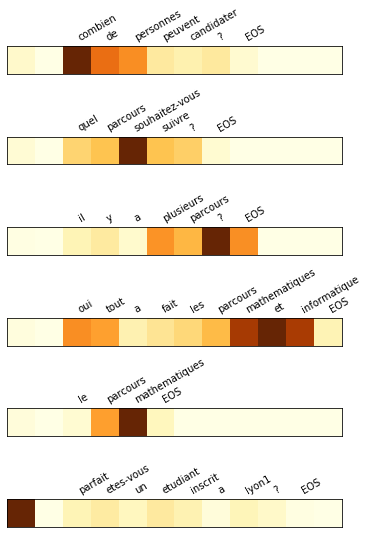

User :  non
target :  pour les etudiants du parcours mathematiques non-inscrits a lyon1 le nombre de places disponibles est de nbreplaces_en_france_mathematiques
predic :  pour les etudiants du parcours mathematiques non-inscrits a lyon1 le nombre de places disponibles est de nbreplaces_en_france_mathematiques


In [65]:
chatbot.eval()
dialogue = dialogues_Master_var[12][:4]
chatbot.showAttention(dialogue)# (15,15))

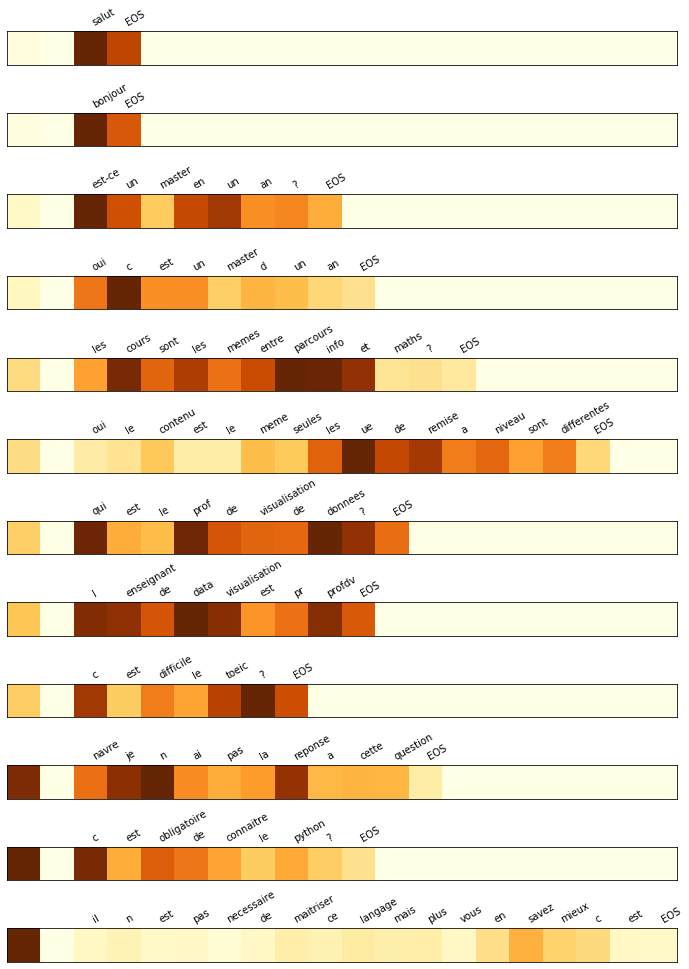

User :  il faut coder en php ?
target :  non aucun tp ne se fera en php
predic :  non aucun tp ne se fera en php


In [41]:
chatbot.eval()
dialogue = dialogues_Master_test_var[1][:7]
chatbot.showAttention(dialogue)

### 6.4.3 Interactive mode

write **quit** or **q** or **eoc** (end of conversation) to close conversation interface :

In [43]:
def ReplaceMotVar(motsVar, raw_sentence):
    sentence = []
    word_list = raw_sentence.split(' ')
    for word in word_list :
        if word in motsVar.keys() :
            sentence.append(motsVar[word])
        else :
            sentence.append(word)
    return ' '.join(sentence)

def InteractiveEvaluation(agent) :
    agent.initMemory()
    while True :
        text = input()
        #print('User : {}'.format(text))
        if text == 'eoc' or text == 'q' or text == 'quit' : 
            break
        reponse, attn1_weights, attn2_weights = chatbot(text)
        reponse = ReplaceMotVar(motsVar, reponse)
        print('Bot  : {}'.format(reponse))

In [61]:
chatbot.eval()
InteractiveEvaluation(chatbot)

salut ma poule
Bot  : bonjour
comment vas tu ?
Bot  : je vais bien merci et vous ?
oui ca va bien
Bot  : j en suis ravi en quoi puis-je vous aider ?
je voudrais savoir a quel point tu sais parler
Bot  : excellent que souhaiteriez-vous savoir ?
c'est au top ta réponse
Bot  : merci
quit


In [44]:
chatbot.eval()
InteractiveEvaluation(chatbot)

salut
Bot  : bonjour
tu vas bien ?
Bot  : je m appelle Cadoc
tres bien cadoc
Bot  : je suis la pour vous aider ?
c'est une question ?
Bot  : je suis la pour vous aider
haaa merci
Bot  : je vous en prie
quit


### 6.5.1 Training with Attention decoder

In [145]:
chatbot.train()
trainer.train(chatbot, dialogues_Master_var, n_iters = 20000, learning_rate=0.01)
#trainer.train(chatbot, dialogues_Master_var, n_iters = 20000, learning_rate=0.005)
#trainer.train(chatbot, dialogues_Master_var, n_iters = 20000, learning_rate=0.0025)

0m 12s (- 40m 55s) (100 0%) 2.9270 11.84
0m 24s (- 41m 7s) (200 1%) 2.3286 11.01
0m 37s (- 41m 2s) (300 1%) 2.4096 11.02
0m 51s (- 41m 42s) (400 2%) 2.2785 10.38
1m 3s (- 41m 33s) (500 2%) 2.4305 11.40
1m 16s (- 41m 28s) (600 3%) 2.7747 13.08
1m 30s (- 41m 39s) (700 3%) 2.6980 9.67
1m 44s (- 41m 38s) (800 4%) 2.5713 10.21
1m 57s (- 41m 37s) (900 4%) 2.6310 10.58
2m 12s (- 41m 56s) (1000 5%) 2.7061 10.13
2m 30s (- 43m 1s) (1100 5%) 2.5968 10.97
2m 44s (- 43m 3s) (1200 6%) 2.8367 10.14
2m 58s (- 42m 43s) (1300 6%) 3.0008 9.93
3m 12s (- 42m 43s) (1400 7%) 2.8631 10.41
3m 26s (- 42m 29s) (1500 7%) 2.8545 9.91
3m 40s (- 42m 11s) (1600 8%) 2.6098 10.52
3m 53s (- 41m 57s) (1700 8%) 2.9465 10.08
4m 7s (- 41m 41s) (1800 9%) 2.7973 10.50
4m 20s (- 41m 18s) (1900 9%) 2.7764 9.94
4m 33s (- 40m 58s) (2000 10%) 2.6915 10.01
4m 50s (- 41m 18s) (2100 10%) 2.7661 9.57
5m 4s (- 41m 5s) (2200 11%) 2.8064 9.82
5m 21s (- 41m 11s) (2300 11%) 2.4426 9.79
5m 34s (- 40m 53s) (2400 12%) 3.0416 10.08
5m 50s (- 4

KeyboardInterrupt: 

In [ ]:
chatbot.train()
trainer.train(chatbot, dialogues_Master_var, n_iters = 20000, learning_rate=0.005)